Notebook to Investigate Base Run's Baroclinic Properties

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as NC

from scipy.optimize import curve_fit
from salishsea_tools import ellipse
from salishsea_tools import viz_tools
from salishsea_tools import tidetools

from matplotlib.patches import Ellipse

(1920, 1, 1)


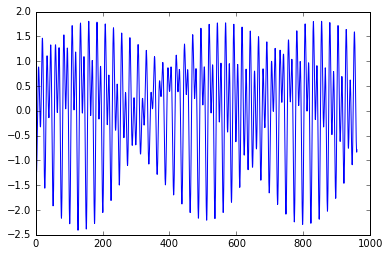

In [3]:
timeinc = 3659558400
fT1 = NC.Dataset('../../myResults/NEMO36_Tides/GmO_Base/PointAtkinson.nc','r')
ssh = fT1.variables['sossheig'][:]
time = (fT1.variables["time_counter"][:]-timeinc)/3600. 
print (ssh.shape)
plt.plot(time,ssh[:,0,0])

In [23]:
uv = NC.Dataset('../../myResults/NEMO36_Tides/GmO_Base/CODAR.nc')
ugrid = uv.variables['vozocrtx']
vgrid = uv.variables['vomecrty']
depths = uv.variables['deptht']
u, v = viz_tools.unstagger(ugrid, vgrid)
lat = uv.variables['nav_lat']
lon = uv.variables['nav_lon']

So initially, I had x-values starting at 241 in Fortran, 240 in Python.  However by averaging, I lose the 240 value and am starting at 241. Similarly in y I should be starting at 381.  I'm not sure however, what the lats and lons I'm getting from the CODAR file are.  Lets take a look at that compared to the bathymetry file.

In [5]:
bathyset = NC.Dataset('../../NEMO-forcing/grid/bathy_downonegrid.nc')
bathy_lat = bathyset['nav_lat']
bathy_lon = bathyset['nav_lon']

And according to research_VENUS, the VENUS east point is at 416, 283 == 49.0419, -123.3176

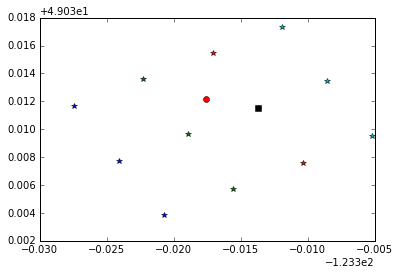

In [6]:
plt.plot(bathy_lon[415:418,281:285], bathy_lat[415:418, 281:285],'*')
plt.plot(bathy_lon[416, 283], bathy_lat[416, 283], 'ks')
plt.plot(-123.3176, 49.0422, 'ro')

Okay, lets go back to the source.  According to: http://venus.uvic.ca/locations/instrument_tables.php#SOGSHALLOW East is at 49 2.531, -123 19.059

In [7]:
east_lat = 49+2.531/60.
east_lon = -(123 + 19.059/60.)

print (east_lat, east_lon)

49.042183333333334 -123.31765


In [8]:
for i in [416,417]:
    for j in [282,283]:
        print (i, j, tidetools.haversine(east_lon, east_lat, bathy_lon[i,j], bathy_lat[i,j]))

416 282 0.2969988994434936
416 283 0.2939856215868898
417 282 0.37109625902852533
417 283 0.36725074117185247


In [9]:
print (lat[0,0], lon[0,0], bathy_lat[380, 240], bathy_lon[380, 240])

48.8182 -123.417 48.8181686401 -123.416664124


Okay, this is what I expected.  The u,v files, however are now starting at 381, 241.  So 416, 283 is 35, 42

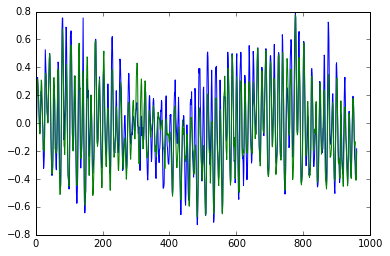

In [10]:
ieast = 35; jeast = 42
icent = 43; jcent = 25
cent_lat = 49.0401; cent_lon = -123.4261
plt.plot(v[:, 0, ieast, jeast])
plt.plot(v[:, 5, ieast, jeast])

In [11]:
print (np.mean(v[:, 0, ieast, jeast]), np.mean(v[:, 5, ieast, jeast]))

-0.0119926 -0.0485445


In [12]:
# function for fitting 6 frequencies and inferring 2 with constant
def sixplustwo(xplus, M2amp, M2pha, K1amp, K1pha, O1amp, O1pha, S2amp, S2pha,
                 N2amp, N2pha, Q1amp, Q1pha, Constant):
    x = xplus[0]

    P1K1amp = xplus[1]
    P1K1pha = xplus[2]
    K2S2amp = xplus[3]
    K2S2pha = xplus[4]
    
    return (M2amp * M2ft * np.cos(M2freq*x - (M2pha - M2uvt) *np.pi/180.) +
             K1amp * K1ft * np.cos(K1freq*x - (K1pha - K1uvt) *np.pi/180.) +
             O1amp * O1ft * np.cos(O1freq*x - (O1pha - O1uvt) *np.pi/180.) +
             S2amp * S2ft * np.cos(S2freq*x - (S2pha - S2uvt) *np.pi/180.) +
             P1K1amp * K1amp *P1ft * np.cos(P1freq*x - (K1pha + P1K1pha - P1uvt) *np.pi/180.) +
             N2amp * N2ft * np.cos(N2freq*x - (N2pha - N2uvt) *np.pi/180.) +
             Q1amp * Q1ft * np.cos(Q1freq*x - (Q1pha - Q1uvt) *np.pi/180.) +
             K2S2amp * S2amp *K2ft * np.cos(K2freq*x - (S2pha + K2S2pha - K2uvt) *np.pi/180.) + Constant )

In [13]:
M2freq = 28.984106 # degrees per hour
M2freq = M2freq*np.pi/180. # radians per hour
#K1
K1freq = 15.041069*np.pi/180.
#O1
O1freq = 13.943036*np.pi/180.
#S2
S2freq = 30.000002*np.pi/180.
#P1
P1freq = 14.958932*np.pi/180.
#N2
N2freq = 28.439730*np.pi/180.
#Q1
Q1freq = 13.398661*np.pi/180.
#K2
K2freq = 30.082138*np.pi/180.

# initial phase calculation
# for Dec 20, 2015
# data for phase output from sbctides.F90; found in ocean.output
K1ft = 1.065578251
K1uvt = 180./np.pi*(-0.125546041827260+2.07252226124830)
M2ft = 0.982281162375735
M2uvt = 180./np.pi*(-12.5992126246319-1.87559884068371)
# Not using here so set to 1/0
O1ft = 1.
O1uvt = 0.
S2ft = 1.0
S2uvt = 0.0
P1ft = 1.0
P1uvt = 0.0
N2ft = 1.0
N2uvt = 0.0
Q1ft = 1.0
Q1uvt = 0.0
K2ft = 1.0
K2uvt = 0.0

In [14]:
sCO = 79
iichoice = [15, 35, 43, 60, 75]; jjchoice = [15, 25, 32, 42, 52, 62]
timeplus = np.zeros([5,960])
P1K1_amp = 0.31; P1K1_pha = -3
K2S2_amp = 0.27; K2S2_pha = 0
v_M2pha = np.zeros((sCO, sCO, 40)); v_M2amp = np.zeros((sCO, sCO, 40))
print (time[0:-1:2].shape)
timeplus[0] = time[0:-1:2]
timeplus[1] = P1K1_amp*np.ones_like(timeplus[0]); timeplus[2] = P1K1_pha*np.ones_like(timeplus[0])
timeplus[3] = K2S2_amp*np.ones_like(timeplus[0]); timeplus[4] = K2S2_pha*np.ones_like(timeplus[0])

for ii in iichoice:
    for jj in jjchoice:
        print (ii, jj)
        for i in range(40):
            if np.abs(v[5,i,ii,jj]) > 0.00000001:
                fitted, cov = curve_fit(sixplustwo, timeplus, v[:,i,ii,jj]) 
                v_M2amp[ii,jj,i] = fitted[0]
                v_M2pha[ii,jj,i] = fitted[1]

(960,)
15 15
15 25
15 32
15 42
15 52
15 62
35 15
35 25
35 32
35 42
35 52
35 62
43 15
43 25
43 32
43 42
43 52
43 62
60 15
60 25
60 32
60 42
60 52
60 62
75 15
75 25
75 32
75 42
75 52
75 62


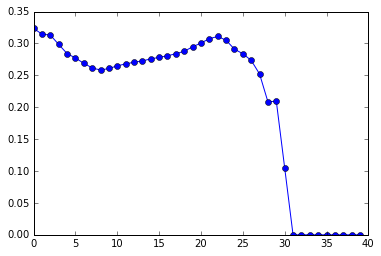

In [15]:
plt.plot(v_M2amp[ieast, jeast],'o-')

In [16]:
u_M2amp = np.zeros((sCO, sCO, 40)); u_M2pha = np.zeros((sCO, sCO, 40))
for ii in iichoice:
    for jj in jjchoice:
        print (ii, jj)
        for i in range(40):
            if np.abs(u[8,i,ii,jj]) > 0.00000001:
                fitted, cov = curve_fit(sixplustwo, timeplus, u[:,i,ii,jj]) 
                u_M2amp[ii,jj,i] = fitted[0]
                u_M2pha[ii,jj,i] = fitted[1]

15 15
15 25
15 32
15 42
15 52
15 62
35 15
35 25
35 32
35 42
35 52
35 62
43 15
43 25
43 32
43 42
43 52
43 62
60 15
60 25
60 32
60 42
60 52
60 62
75 15
75 25
75 32
75 42
75 52
75 62


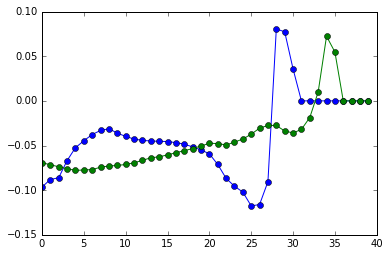

In [17]:
plt.plot(u_M2amp[ieast, jeast],'o-')
plt.plot(u_M2amp[icent, jcent],'o-')

In [18]:
 CX, SX, CY, SY, ap, am, ep, em, major, minor, theta, phase = ellipse.ellipse_params(u_M2amp, u_M2pha, v_M2amp, v_M2pha)

(79, 79, 40)


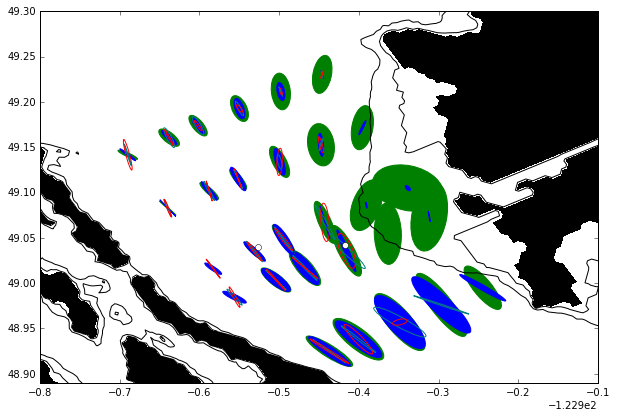

In [35]:
scale = 0.2
print (major.shape)
grid_B = '../../NEMO-forcing/grid/bathy_downonegrid.nc'
fig, ax = plt.subplots(1, 1, figsize=(10,10))
viz_tools.set_aspect(ax) 
for ii in iichoice:
    for jj in jjchoice:
        ellsc = Ellipse(
                xy=(lon[ii,jj], lat[ii,jj]),
                width=scale * major[ii,jj,0],
                height=scale * minor[ii,jj,0],
                angle=theta[ii,jj,0]+29,
                color='green')
        ax.add_artist(ellsc)
        ellsc = Ellipse(
                xy=(lon[ii,jj], lat[ii,jj]),
                width=scale * major[ii,jj, 8],
                height=scale * minor[ii,jj, 8],
                angle=theta[ii,jj, 8]+29,
                color='blue')
        ax.add_artist(ellsc)
        ellsc = Ellipse(
                xy=(lon[ii,jj], lat[ii,jj]),
                width=scale * major[ii,jj,25],
                height=scale * minor[ii,jj,25],
                angle=theta[ii,jj,25]+29,
                edgecolor='teal', facecolor='none')
        ax.add_artist(ellsc)
        ellsc = Ellipse(
                xy=(lon[ii,jj], lat[ii,jj]),
                width=scale * major[ii,jj,29],
                height=scale * minor[ii,jj,29],
                angle=theta[ii,jj,29]+29,
                edgecolor='red', facecolor='none')
        ax.add_artist(ellsc)
viz_tools.plot_land_mask(ax, grid_B, coords='map')
viz_tools.plot_coastline(ax, grid_B, coords='map', isobath=5)
viz_tools.plot_coastline(ax, grid_B, coords='map', isobath=20)
ax.set_xlim(-123.7, -123.)
ax.set_ylim(48.89, 49.3)
plt.plot(east_lon, east_lat, 'wo')
plt.plot(cent_lon, cent_lat, 'wo')

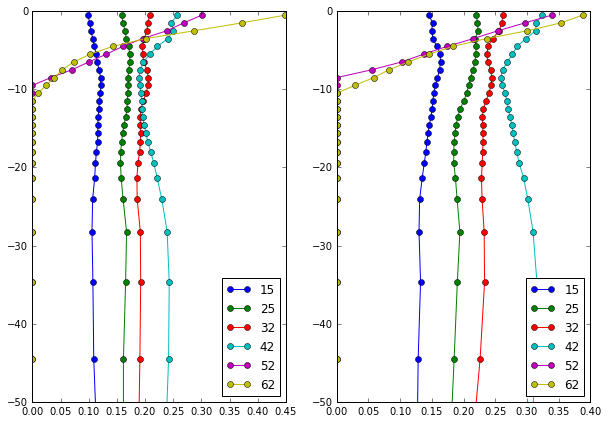

In [104]:
fig, axs = plt.subplots(1,2,figsize=(10,7))
for ii in [43]:
    for jj in jjchoice:
        axs[0].plot(major[ii, jj], -depths[:], 'o-', label=jj)
axs[0].set_ylim(-50,0)
axs[0].legend(loc='lower right')
for ii in [35]:
    for jj in jjchoice:
        axs[1].plot(major[ii, jj], -depths[:], 'o-', label=jj)
axs[1].set_ylim(-50,0)
axs[1].legend(loc='lower right')

In [103]:
eastobs = np.loadtxt('/ocean/mhalvers/research/adcp/east_ADCP_M2_ellipse_params.txt', skiprows=2, unpack=True)
central = np.loadtxt('/ocean/mhalvers/research/adcp/central_ADCP_M2_ellipse_params.txt', skiprows=2, unpack=True)

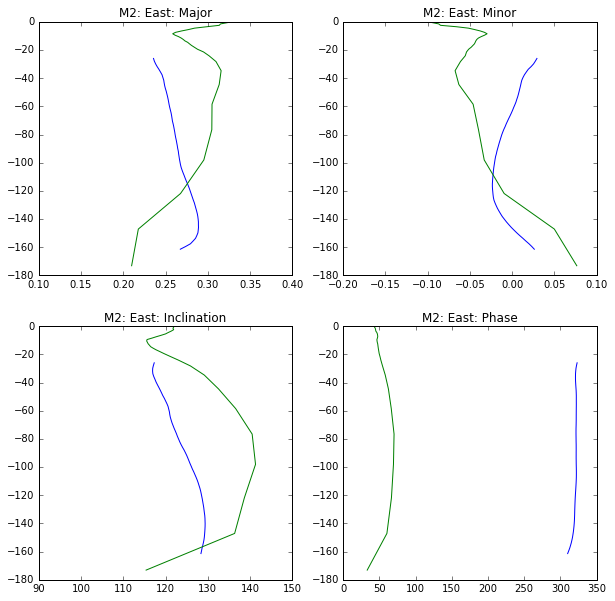

In [99]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
axs[0,0].plot(eastobs[1]/100., -eastobs[0])
axs[0,0].plot(major[ieast, jeast, :30], -depths[:30])
axs[0,0].set_xlim((0.1,0.4))
axs[0,0].set_title("M2: East: Major")
axs[0,1].plot(eastobs[2]/100., -eastobs[0])
axs[0,1].plot(minor[ieast, jeast, :30], -depths[:30])
axs[0,1].set_xlim((-0.2,0.1))
axs[0,1].set_title("M2: East: Minor")
axs[1,0].plot(eastobs[3], -eastobs[0])
axs[1,0].plot(theta[ieast, jeast, :30]+29, -depths[:30])
axs[1,0].set_xlim((90,150))
axs[1,0].set_title("M2: East: Inclination")
axs[1,1].plot(eastobs[4], -eastobs[0])
axs[1,1].plot(phase[ieast, jeast, :30], -depths[:30])
#axs[1,0].set_xlim((90,150))
axs[1,1].set_title("M2: East: Phase")

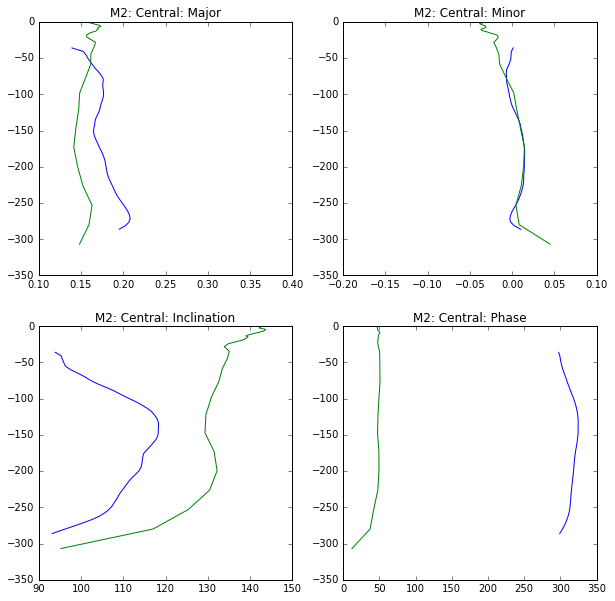

In [102]:
fig, axs = plt.subplots(2,2,figsize=(10,10))
axs[0,0].plot(central[1]/100., -central[0])
axs[0,0].plot(major[icent, jcent, :35], -depths[:35])
axs[0,0].set_xlim((0.1,0.4))
axs[0,0].set_title("M2: Central: Major")
axs[0,1].plot(central[2]/100., -central[0])
axs[0,1].plot(minor[icent, jcent, :35], -depths[:35])
axs[0,1].set_xlim((-0.2,0.1))
axs[0,1].set_title("M2: Central: Minor")
axs[1,0].plot(central[3], -central[0])
axs[1,0].plot(theta[icent, jcent, :35]+29, -depths[:35])
axs[1,0].set_xlim((90,150))
axs[1,0].set_title("M2: Central: Inclination")
axs[1,1].plot(central[4], -central[0])
axs[1,1].plot(phase[icent, jcent, :35], -depths[:35])
#axs[1,0].set_xlim((90,150))
axs[1,1].set_title("M2: Central: Phase")